In [1]:
import numpy as np
import pandas as pd
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

c:\Users\Krishna\anaconda3\envs\gen_rfm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#url = r"https://www.dropbox.com/s/up0k1i6btb8qmb7/usa_00006.csv?dl=1"
url = r"C:\Users\Krishna\Dropbox\usa_00006.csv"
data = pd.read_csv(url)
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,COUNTYFIP,METRO,STRATA,GQ,...,MARRINYR,RACE,RACED,EDUC,EDUCD,EMPSTAT,EMPSTATD,INCTOT,SEX_SP,AGE_SP
0,2010,201001,2,80,527.68,2010000000021,97,2,220001,1,...,1,1,100,11,114,1,10,17000,2.0,26.0
1,2010,201001,2,80,527.68,2010000000021,97,2,220001,1,...,1,1,100,7,71,1,10,13000,1.0,25.0
2,2010,201001,2,80,527.68,2010000000021,97,2,220001,1,...,0,1,100,0,2,0,0,9999999,NaN,NaN
3,2010,201001,8,380,816.00,2010000000081,0,2,190001,4,...,0,2,200,7,71,3,30,1200,NaN,NaN
4,2010,201001,19,1028,402.56,2010000000191,73,4,90301,1,...,1,1,100,6,63,1,10,50000,2.0,41.0


In [3]:
data = data.dropna()

In [4]:
data["MARRINYR"].value_counts()
#married last year "yes" is value 2

1    1579995
0     101195
2      45678
Name: MARRINYR, dtype: int64

In [5]:
data.columns

Index(['YEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'COUNTYFIP',
       'METRO', 'STRATA', 'GQ', 'SSMC', 'PERNUM', 'PERWT', 'SEX', 'AGE',
       'MARST', 'MARRINYR', 'RACE', 'RACED', 'EDUC', 'EDUCD', 'EMPSTAT',
       'EMPSTATD', 'INCTOT', 'SEX_SP', 'AGE_SP'],
      dtype='object')

In [6]:
columns_to_drop = ['SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'STRATA', 'GQ', 
                    'PERNUM', 'PERWT','RACED', 'EDUCD', 'EMPSTATD']

data = data.drop(columns = columns_to_drop)
data.head()

,YEAR,COUNTYFIP,METRO,SSMC,SEX,AGE,MARST,MARRINYR,RACE,EDUC,EMPSTAT,INCTOT,SEX_SP,AGE_SP
1586310,2013,0,1,0.0,1,59,1,1,1,6,1,90000,2.0,56.0
1586311,2013,0,1,0.0,2,56,1,1,1,6,1,46000,1.0,59.0
1586313,2013,0,2,0.0,1,55,1,1,1,6,1,75000,2.0,52.0
1586314,2013,0,2,0.0,2,52,1,1,1,10,1,100000,1.0,55.0
1586315,2013,73,4,0.0,1,60,1,1,1,11,1,444000,2.0,44.0


In [7]:
data.shape

(1726868, 14)

In [8]:
data = data[data["MARRINYR"] == 2] 
"""married year = 2 is the option which tells us that the
person married in the last year"""
data.shape

(45678, 14)

In [9]:
data['SEX_SP'] = data['SEX_SP'].astype(int)

"""
Creating the variable called 'same_sex_couple' from existing variables of SEX and SEX_SP
This variable is the treatment variable.
"""

data.loc[:, 'same_sex_couple'] = 0
data.loc[data['SEX'] == data['SEX_SP'], 'same_sex_couple'] = 1


In [10]:
check_data = data[['SEX',
                    'SEX_SP',
                    'same_sex_couple']].copy()
check_data

,SEX,SEX_SP,same_sex_couple
1586499,2,1,0
1586500,1,2,0
1586647,1,2,0
1586648,2,1,0
1586893,1,2,0
...,...,...,...
5403318,2,1,0
5403362,2,1,0
5403363,1,2,0
5403424,1,2,0


In [11]:
temp_df = data[data["same_sex_couple"] == 1]
temp_df["YEAR"].shape

(2160,)

In [12]:
data = data[data["AGE"] > 18] 
data = data[data["MARST"] == 1]
data.loc[:, 'married_year'] = data["YEAR"] - 1
data.head()


,YEAR,COUNTYFIP,METRO,SSMC,SEX,AGE,MARST,MARRINYR,RACE,EDUC,EMPSTAT,INCTOT,SEX_SP,AGE_SP,same_sex_couple,married_year
1586499,2013,0,1,0.0,2,26,1,2,1,10,2,10000,1,31.0,0,2012
1586500,2013,0,1,0.0,1,31,1,2,1,6,1,35000,2,26.0,0,2012
1586647,2013,81,4,0.0,1,31,1,2,1,7,1,20000,2,34.0,0,2012
1586648,2013,81,4,0.0,2,34,1,2,1,11,2,18100,1,31.0,0,2012
1586893,2013,73,4,0.0,1,31,1,2,1,10,1,50000,2,25.0,0,2012


In [13]:
data["married_year"].value_counts() #to understand how many people married in each year.

2016    7102
2015    6874
2014    6583
2013    6541
2018    6154
2012    6112
2017    5951
Name: married_year, dtype: int64

In [14]:
features = data[['SEX', 'AGE', 'RACE', 'EDUC', 'EMPSTAT']] #Xi
treatment = data['same_sex_couple'] #Wi
instrument = data['INCTOT'] #Zi

In [15]:
outcome = (data["married_year"] > 2015).astype(int)
outcome

1586499    0
1586500    0
1586647    0
1586648    0
1586893    0
          ..
5403318    1
5403362    1
5403363    1
5403424    1
5403425    1
Name: married_year, Length: 45317, dtype: int32

In [16]:
X = features
y = outcome
T = treatment
Z = instrument

X_train, X_test, y_train, y_test = train_test_split(
                                     X, y, test_size=0.40, random_state=42)

In [28]:
model = CausalForestDML(criterion='mse', n_estimators=200, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     subforest_size=4,
                     verbose=0, n_jobs=-1, random_state=123)

In [31]:
model.fit(y, T, X=X, W=Z)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [19]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

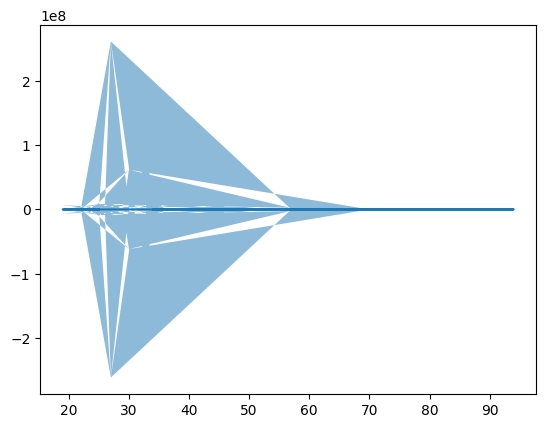

In [20]:
for t in range(1):
    plt.plot(X_test.iloc[:,1], point[:, t])
    if est.inference:
        plt.fill_between(X_test.iloc[:, 1], lb[:, t], ub[:, t], alpha=.5)
plt.show()

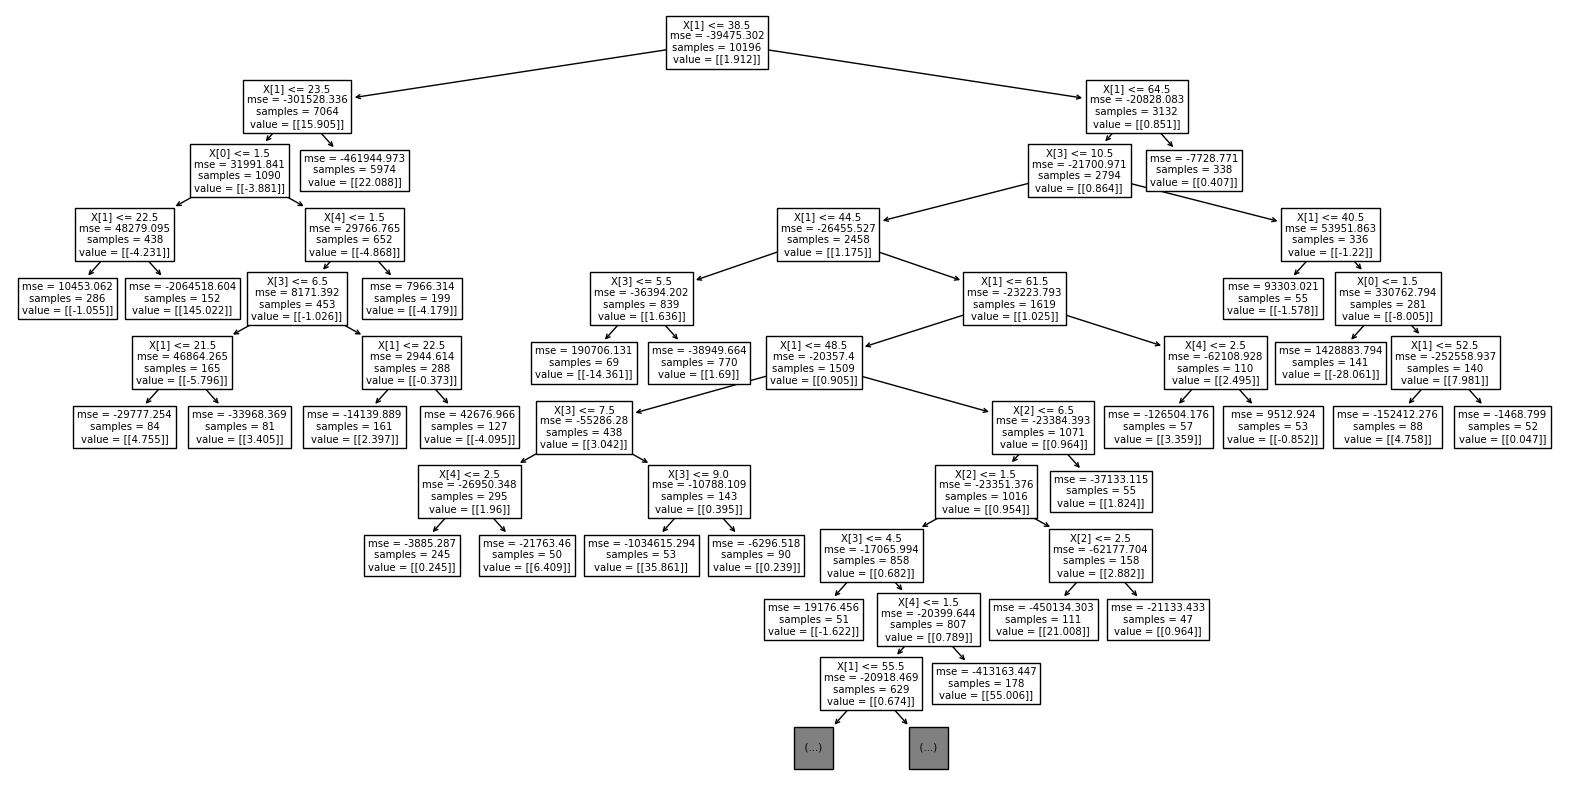

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=10)
plt.show()

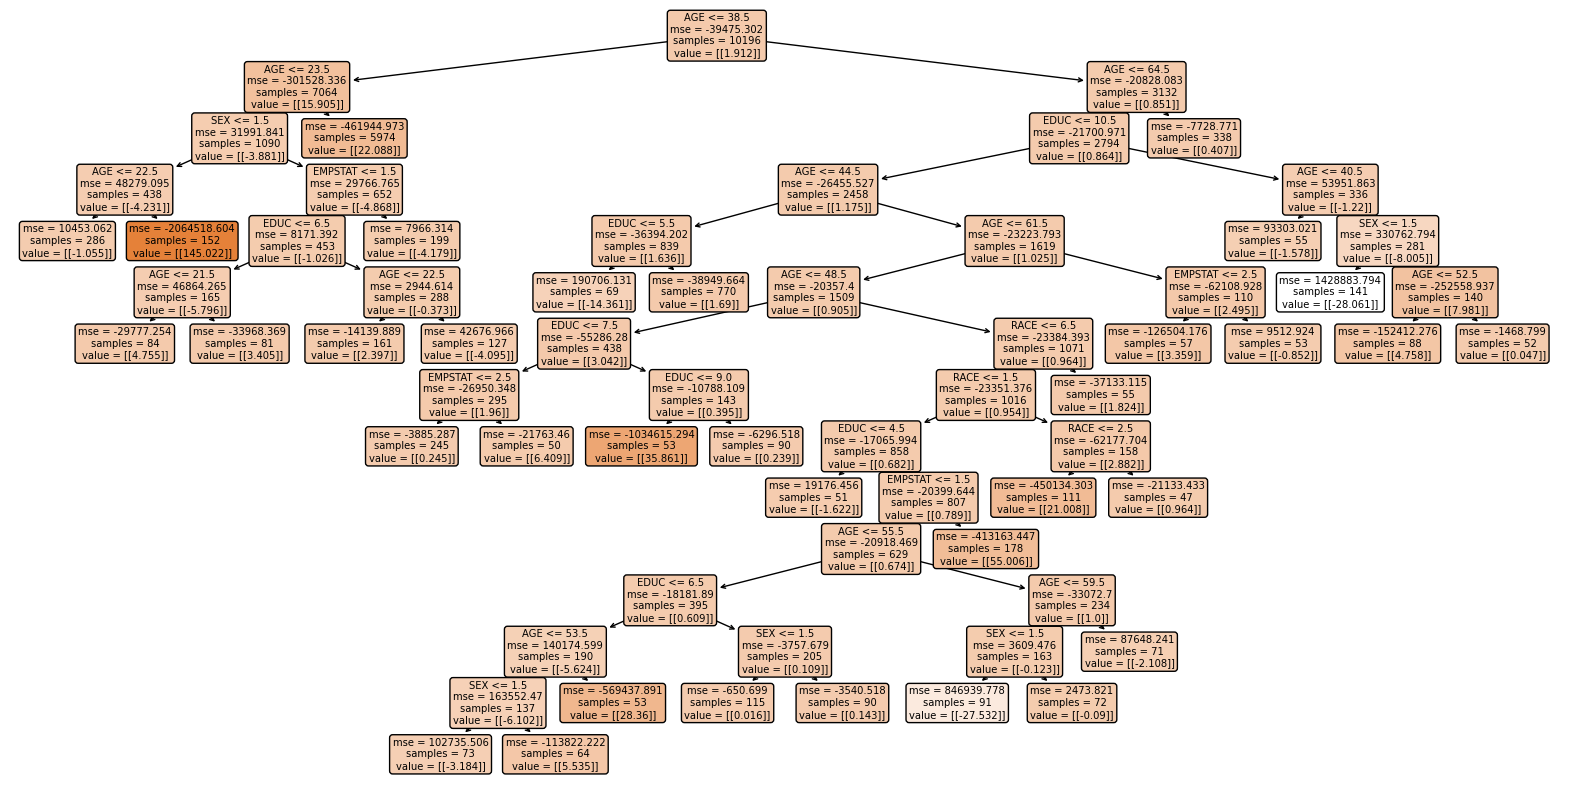

In [22]:
plt.figure(figsize=(20, 10))
plot_tree(est[0],
        filled = True,
        rounded = True,
        class_names = ["yes","no"],
        feature_names = X.columns);

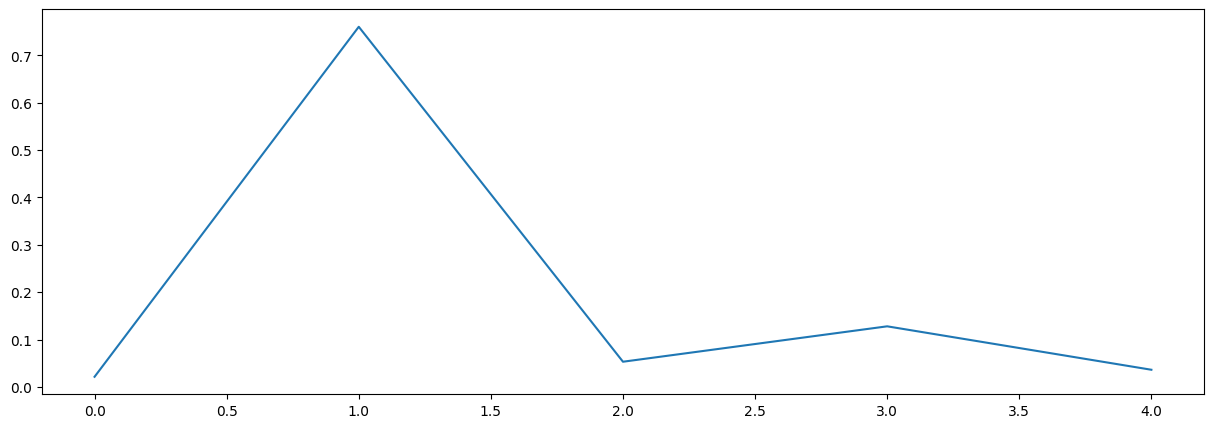

In [23]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


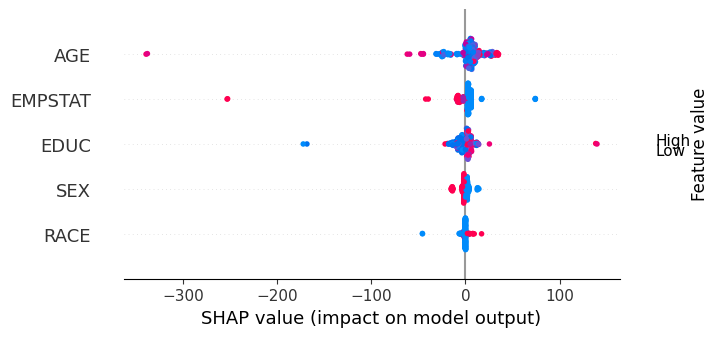

In [24]:
import shap
explainer = shap.explainers.Tree(est, shap.maskers.Independent(X, max_samples=200))
shap_values = explainer(X[:250])
shap.plots.beeswarm(shap_values)


In [25]:
shap.plots.beeswarm(shap_values[:, :, 100])
shap.plots.beeswarm(shap_values[:, :, 200])

IndexError: too many indices for array